# Import libraries and define model to use

In [1]:
#!pip install pandas
#!pip install matplotlib
#!pip install numpy

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from ultralytics import RTDETR
import torch
import cv2
import matplotlib.patches as mpatches

rootFolder: str = os.path.join("mixed", "results")

# yolov11n_250_epochs_10_patience
chosenModel_specs: dict = {
        "model": "yolo11s",
        "epochs": 300,
        "patience": 100,
        "training_time": 40.5, # in hours
        "optimizer": "AdamW",
        "batch-size": 16,
        "lr0": 0.0001,
        "weight_decay": 0.0001,
        "train_path": os.path.join(rootFolder, "yolo11n_300_100_16_AdamW_0.0001_0.0001_0", "train")
    }

if not os.path.exists(chosenModel_specs["train_path"]):
    raise ValueError(f"File path {chosenModel_specs["train_path"]} isn't present!")

# Making predictions on Test Images

In [2]:
# Load the model
best_model_path = os.path.join(chosenModel_specs["train_path"], "weights", "best.pt")
model = YOLO(best_model_path)

## Test prediction times

In [3]:
prediction_stats: list = []

In [4]:
# Function to perform ship detections
def traffic_detect(img_path):
    
    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)
    prediction_stats.append(detect_result)

    # Plot the detections
    detect_img = detect_result[0].plot()
    
    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    
    return detect_img


0: 640x640 1 redlight, 58.4ms
Speed: 3.3ms preprocess, 58.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 crosswalk, 53.4ms
Speed: 2.1ms preprocess, 53.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 redlight, 41.9ms
Speed: 1.4ms preprocess, 41.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 crosswalks, 51.0ms
Speed: 1.2ms preprocess, 51.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 crosswalk, 47.7ms
Speed: 1.0ms preprocess, 47.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 crosswalk, 53.0ms
Speed: 1.8ms preprocess, 53.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 crosswalk, 38.9ms
Speed: 2.0ms preprocess, 38.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 redlight, 38.6ms
Speed: 1.0ms preprocess, 38.6ms inference, 0.4ms postprocess per im

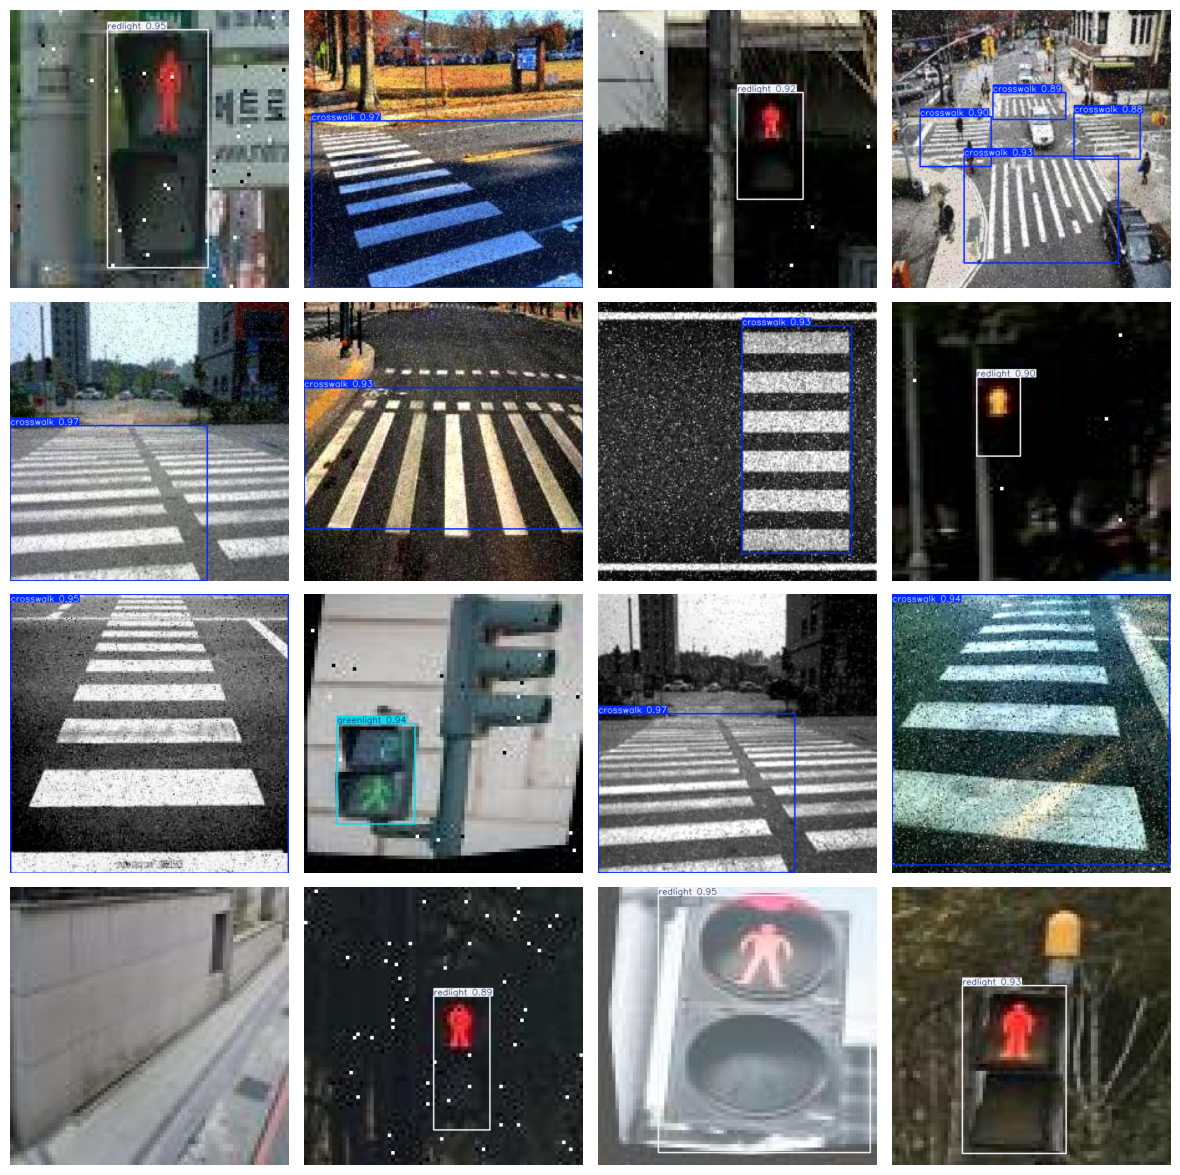

In [5]:
import random

# Define the directory where the custom images are stored
custom_image_dir = os.path.join("mixed", "dataset", "yolo_format", "test", "images")

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 16)

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):
    
    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4
    
    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = traffic_detect(img_path)
    
    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)

num_objects = [len(r[0].boxes) for r in prediction_stats]  # Use r.boxes for the bounding box data
# if 0 not in num_objects:
#    raise ValueError("Please run until at least one image is background with no objects!")


### Plot the prediction stats for the selected images

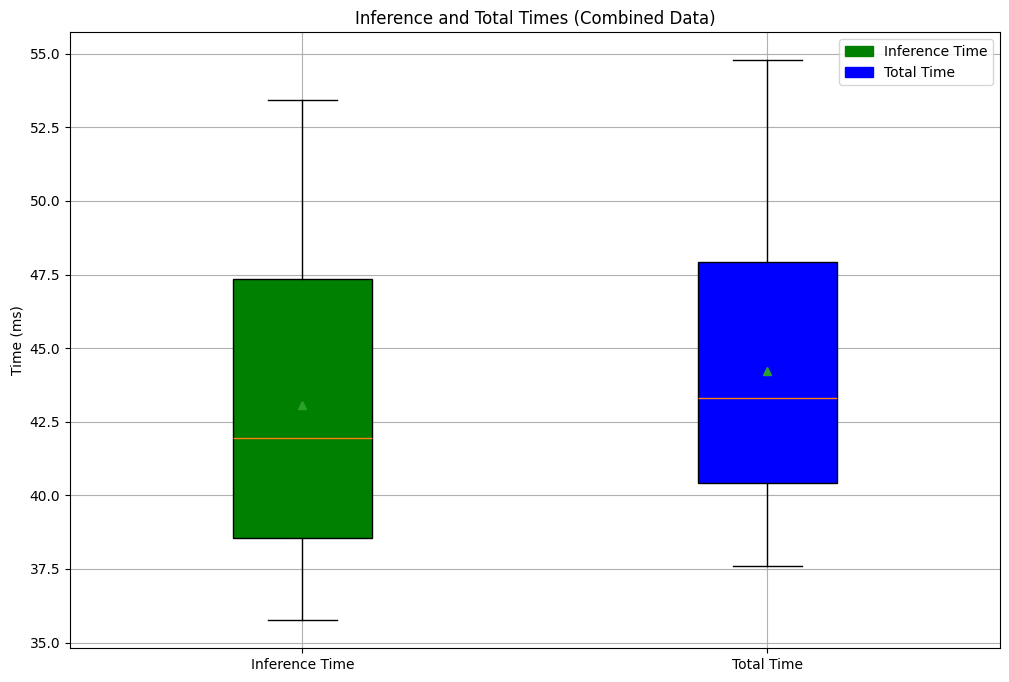

In [6]:
# Extract data
num_objects = [len(r[0].boxes) for r in prediction_stats]  # Use r.boxes for the bounding box data
preprocess_times = [r[0].speed["preprocess"] for r in prediction_stats]
inference_times = [r[0].speed["inference"] for r in prediction_stats]
postprocess_times = [r[0].speed["postprocess"] for r in prediction_stats]
total_times = [p + i + post for p, i, post in zip(preprocess_times, inference_times, postprocess_times)]

# Extract data (no distinction between number of objects)
inference_times_all = [r[0].speed["inference"] for r in prediction_stats][1:]
total_times_all = [p + i + post for p, i, post in zip(preprocess_times, inference_times_all, postprocess_times)][1:]

# Calculate averages and confidence intervals
def compute_stats(data):
    mean = np.mean(data)
    conf_interval = 1.96 * np.std(data) / np.sqrt(len(data))
    return mean, conf_interval

inference_stats_all = compute_stats(inference_times_all)
total_stats_all = compute_stats(total_times_all)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot inference times
ax.boxplot(
    [inference_times_all],
    positions=[0],
    widths=0.3,
    patch_artist=True,
    boxprops=dict(facecolor="green"),
    showmeans=True,
)

# Plot total times
ax.boxplot(
    [total_times_all],
    positions=[1],
    widths=0.3,
    patch_artist=True,
    boxprops=dict(facecolor="blue"),
    showmeans=True,
)

# Configure plot
ax.set_xticks([0, 1])
ax.set_xticklabels(["Inference Time", "Total Time"])
ax.set_title("Inference and Total Times (Combined Data)")
ax.set_ylabel("Time (ms)")
green_patch = mpatches.Patch(color="green", label="Inference Time")
blue_patch = mpatches.Patch(color="blue", label="Total Time")
ax.legend(handles=[green_patch, blue_patch])
plt.grid(True)
plt.show()


In [7]:
# Print statistics for inference and total times

# Compute stats for 0 objects and multiple objects
def print_stats(label, data):
    mean, conf_interval = compute_stats(data)
    print(f"{label}:")
    print(f"  Mean: {mean:.2f} ms")
    print(f"  95% Confidence Interval: ±{conf_interval:.2f} ms")
    print("-" * 40)

# Print stats
print_stats("Inference Time ", inference_times_all)
print_stats("Total Time for Multiple Objects", total_times_all)

Inference Time :
  Mean: 43.07 ms
  95% Confidence Interval: ±2.94 ms
----------------------------------------
Total Time for Multiple Objects:
  Mean: 44.23 ms
  95% Confidence Interval: ±2.77 ms
----------------------------------------


## Show the YOLO output vs the labeled data

In [8]:
# Function to parse the label file for a given image
def parse_labels(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    labels = []
    for line in lines:
        # Split the line into parts
        parts = line.strip().split()
        
        # Ensure the line has at least 5 parts
        if len(parts) < 5:
            raise ValueError(f"Invalid label line: {line.strip()} (expected at least 5 values)")
        
        # Extract the necessary fields
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:5])
        
        # Append the parsed label
        labels.append((class_id, x_center, y_center, width, height))
    return labels


# Function to perform detections and overlay bounding boxes
def traffic_detect_2(img_path, label_path):
    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)

    # Plot the detections (YOLO detections)
    detect_img = detect_result[0].plot()

    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

    # Parse the labels from the label file
    labels = parse_labels(label_path)

    # Overlay the label bounding boxes (ground truth)
    for label in labels:
        class_id, x_center, y_center, width, height = label
        # Convert from normalized to pixel coordinates
        h, w, _ = img.shape
        x_center, y_center = int(x_center * w), int(y_center * h)
        width, height = int(width * w), int(height * h)

        # Determine the color based on class_id
        if class_id == 0:  # Crosswalk
            color = (0, 255, 0)  # Green
        elif class_id == 1:  # Greenlight
            color = (255, 255, 0)  # Cyan
        elif class_id == 2:  # Redlight
            color = (0, 0, 255)  # Red
        else:
            color = (255, 255, 255)  # Default to white for unexpected class_ids

        # Draw the label bounding box (ground truth)
        cv2.rectangle(detect_img, 
                      (x_center - width // 2, y_center - height // 2), 
                      (x_center + width // 2, y_center + height // 2), 
                      color, 2)  # Color based on class_id
        # Optionally, add a label text
        label_text = {0: 'Crosswalk', 1: 'Greenlight', 2: 'Redlight'}.get(class_id, 'Unknown')
        cv2.putText(detect_img, label_text, 
                    (x_center - width // 2, y_center - height // 2 - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return detect_img



0: 640x640 1 redlight, 41.9ms
Speed: 1.5ms preprocess, 41.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 crosswalk, 45.0ms
Speed: 1.8ms preprocess, 45.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 redlight, 41.2ms
Speed: 1.3ms preprocess, 41.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 crosswalks, 36.7ms
Speed: 1.2ms preprocess, 36.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 crosswalk, 44.7ms
Speed: 1.2ms preprocess, 44.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 crosswalk, 57.3ms
Speed: 1.7ms preprocess, 57.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 crosswalk, 51.4ms
Speed: 2.5ms preprocess, 51.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 redlight, 57.1ms
Speed: 1.5ms preprocess, 57.1ms inference, 3.8ms postprocess per im

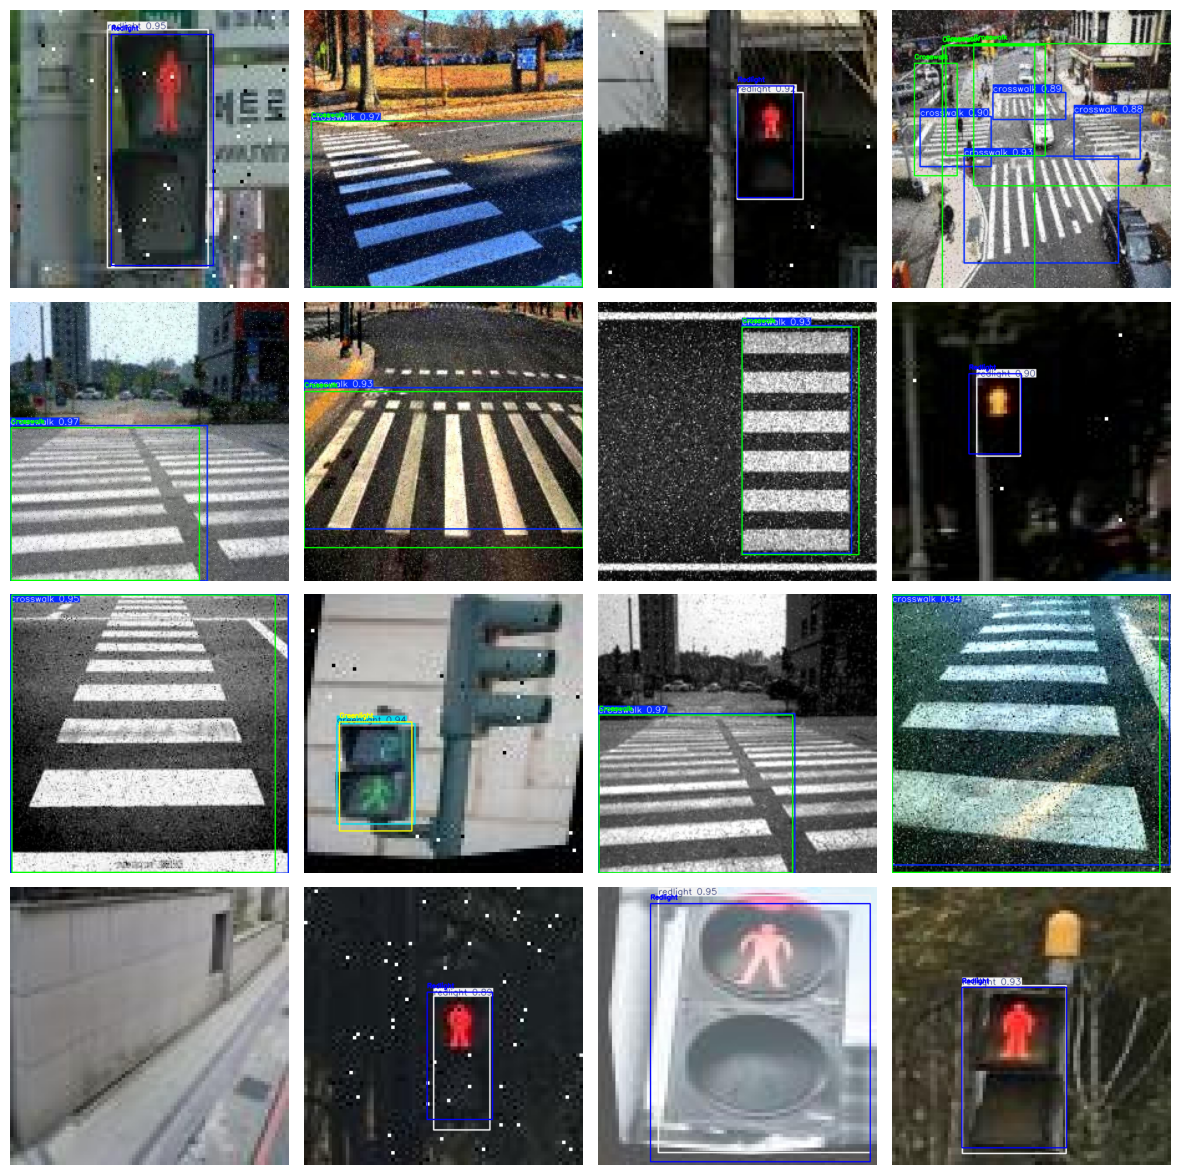

In [9]:
# Define the directory where the custom images are stored
custom_image_dir = os.path.join("mixed", "dataset", "yolo_format", "test", "images")
label_dir = os.path.join("mixed", "dataset", "yolo_format", "test", "labels")


# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select n random images from the list
# selected_images = random.sample(image_files, 16) - Use the ones defined before

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):
    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4
    
    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    label_path = os.path.join(label_dir, img_file.replace('.jpg', '.txt'))  # Assuming labels have the same name as images but with .txt extension
    detect_img = traffic_detect_2(img_path, label_path)
    
    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

# Check the model performance with a video

In [10]:
# Load the model
best_model_path = os.path.join(chosenModel_specs["train_path"], "weights", "best.pt")
model = YOLO(best_model_path)  # Load the PyTorch model
base_output_dir: str = os.path.join("assets", "output")

# Video input and output paths
# Video 1
#video_name = "walking_porto_downscaled.mp4"
#input_video_path = os.path.join("assets", "video_test_1", video_name)
#output_video_path = os.path.join(base_output_dir, "video_test_1", video_name)

# Video 2
# video_name = "walking_porto_1_downscaled.mp4"
# input_video_path = os.path.join("assets", "video_test_2", video_name)
# output_video_path = os.path.join(base_output_dir, "video_test_2", video_name)

# Video 3
video_name = "walking_porto_2_downscaled.mp4"
input_video_path = os.path.join("assets", "video_test_2", video_name)
output_video_path = os.path.join(base_output_dir, video_name)

In [11]:

if not os.path.exists(base_output_dir):
    os.makedirs(base_output_dir)

# Open the input video
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()

# Get the video properties (frame width, height, and frames per second)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Define the codec and create a VideoWriter object to save the output
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change the codec if necessary
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Process each frame in the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Run the model on the current frame
    results = model(frame)  # Perform inference on the frame

    # Parse the results and draw bounding boxes on the frame
    for result in results[0].boxes:  # Access the boxes directly
        x1, y1, x2, y2 = result.xyxy[0]  # Get the bounding box coordinates (x1, y1, x2, y2)
        conf = result.conf[0]  # Confidence score
        cls = result.cls[0]  # Class index

        label = f"{model.names[int(cls)]}: {conf:.2f}"

        # Draw the bounding box and label on the frame
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
        cv2.putText(frame, label, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Write the processed frame to the output video
    out.write(frame)

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Video processing complete. Output saved to {output_video_path}")


0: 640x640 (no detections), 49.4ms
Speed: 1.8ms preprocess, 49.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 53.9ms
Speed: 1.6ms preprocess, 53.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 60.1ms
Speed: 5.1ms preprocess, 60.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 48.6ms
Speed: 1.2ms preprocess, 48.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 40.1ms
Speed: 1.7ms preprocess, 40.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 39.6ms
Speed: 1.1ms preprocess, 39.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 43.8ms
Speed: 1.2ms preprocess, 43.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 59.4ms
Speed: 1.8ms preprocess, 59.4ms i

KeyboardInterrupt: 